# Intel Stock Price (INTC) Forecasting -- DNN Regression

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('content/INTC.csv')
# Colab
INTC = pd.read_csv('INTC.csv')
INTC

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400
...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [ ]:
# 1.1 Convert date
#df['Date']=df.iloc[:,[0]]
df = INTC.copy()
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%d')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,41.632813,43.687500,41.625000,43.500000,25.214338,57710200
1,2000-01-04,42.718750,43.937500,41.125000,41.468750,24.036938,51019600
2,2000-01-05,41.500000,42.937500,40.250000,41.812500,24.236191,52389000
3,2000-01-06,40.875000,41.687500,39.093750,39.375000,22.823311,55171200
4,2000-01-07,38.750000,41.000000,38.687500,41.000000,23.765236,41096400
...,...,...,...,...,...,...,...
5885,2023-05-24,29.309999,29.490000,28.820000,29.000000,29.000000,28045800
5886,2023-05-25,28.290001,28.290001,26.860001,27.400000,27.400000,78009400
5887,2023-05-26,27.440001,29.090000,27.100000,29.000000,29.000000,71879700
5888,2023-05-30,29.700001,30.040001,29.000000,29.990000,29.990000,54874800


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5890.000000,5890.000000,5890.000000,5890.000000,5890.000000,5.890000e+03
mean,31.988597,32.413706,31.570697,31.987438,24.307041,4.710554e+07
std,13.247702,13.443116,13.063646,13.249626,13.257236,2.573677e+07
min,12.170000,12.630000,12.050000,12.080000,7.711779,1.155400e+06
25%,21.760000,22.030001,21.510000,21.792500,14.104247,2.771312e+07
50%,27.590000,27.920000,27.219999,27.600000,18.400957,4.345010e+07
75%,37.230000,37.689999,36.882500,37.209999,30.761747,6.042370e+07
max,75.625000,75.828125,73.625000,74.875000,63.348766,3.093476e+08


In [ ]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5890 entries, 0 to 5889
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5890 non-null   datetime64[ns]
 1   Open       5890 non-null   float64       
 2   High       5890 non-null   float64       
 3   Low        5890 non-null   float64       
 4   Close      5890 non-null   float64       
 5   Adj Close  5890 non-null   float64       
 6   Volume     5890 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 322.2 KB


In [ ]:
new_df=df.iloc[:,[0,4]].copy()
new_df

,Date,Close
0,2000-01-03,43.500000
1,2000-01-04,41.468750
2,2000-01-05,41.812500
3,2000-01-06,39.375000
4,2000-01-07,41.000000
...,...,...
5885,2023-05-24,29.000000
5886,2023-05-25,27.400000
5887,2023-05-26,29.000000
5888,2023-05-30,29.990000


In [ ]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df_describe = new_df.describe()
new_df_describe
#new_df_describe.to_csv('new_df_close.csv')

,Close
count,5890.000000
mean,31.987438
std,13.249626
min,12.080000
25%,21.792500
50%,27.600000
75%,37.209999
max,74.875000


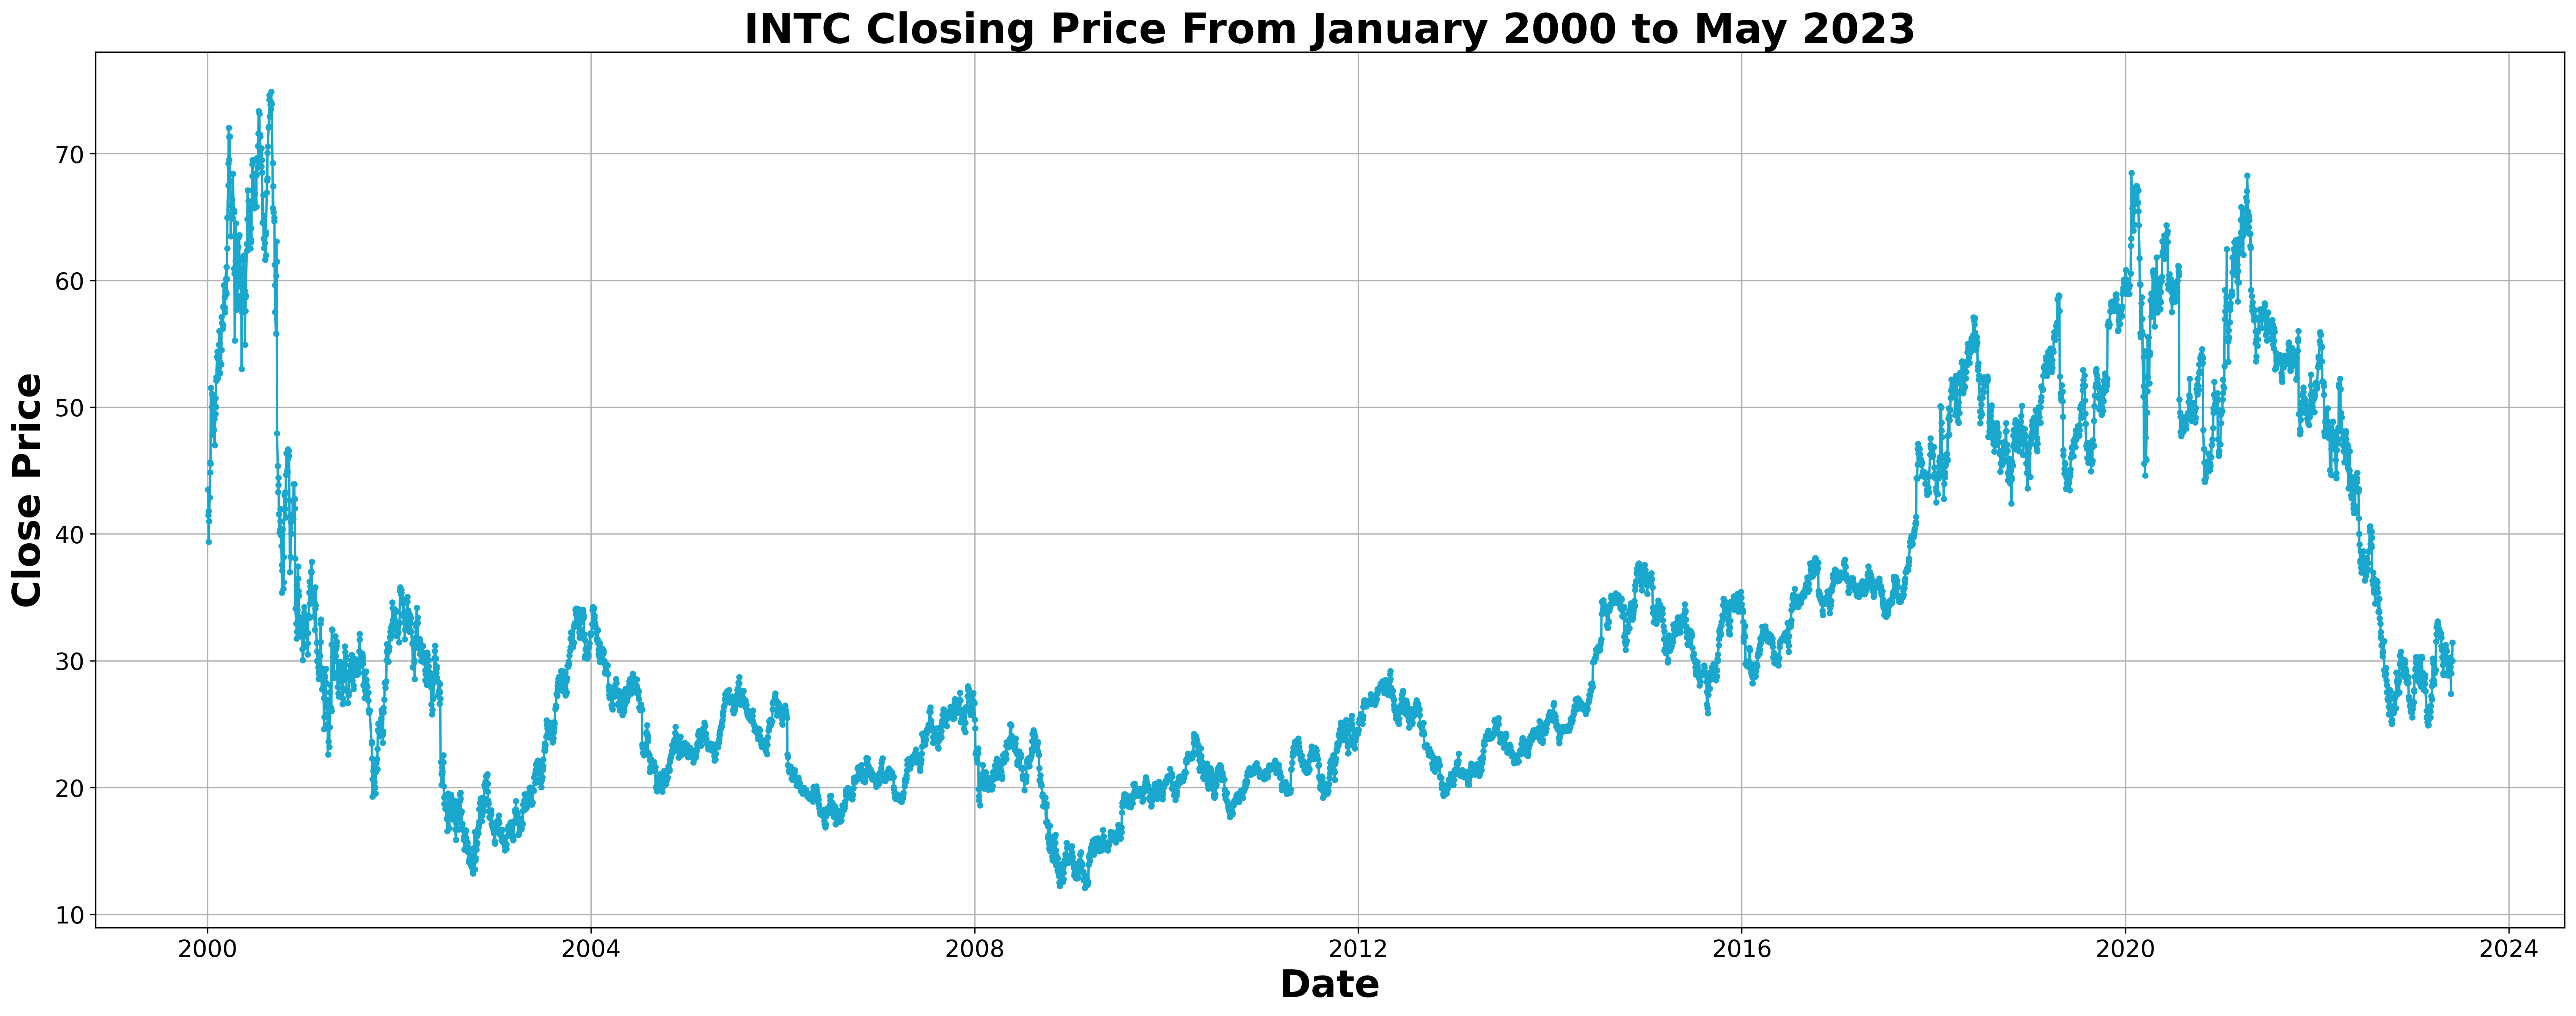

In [ ]:
# Plot Close and its corresponding date
# Figure setting
plt.figure(figsize=(28,10),dpi=300)
plt.title('INTC Closing Price From January 2000 to May 2023', weight='bold', fontsize=26)
plt.xlabel('Date', weight='bold', fontsize=24)
plt.ylabel('Close Price', weight='bold', fontsize=24)

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'], marker='.', color = '#19A7CE')

# Set the axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid('on')
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [ ]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000-01-03,43.500000,NaN,NaN,NaN
1,2000-01-04,41.468750,43.50000,NaN,NaN
2,2000-01-05,41.812500,41.46875,43.500000,NaN
3,2000-01-06,39.375000,41.81250,41.468750,43.500000
4,2000-01-07,41.000000,39.37500,41.812500,41.468750
...,...,...,...,...,...
5885,2023-05-24,29.000000,29.51000,30.280001,29.930000
5886,2023-05-25,27.400000,29.00000,29.510000,30.280001
5887,2023-05-26,29.000000,27.40000,29.000000,29.510000
5888,2023-05-30,29.990000,29.00000,27.400000,29.000000


In [ ]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df
#clean_df.to_csv('new_clean_df.csv')

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000-01-06,39.375000,41.81250,41.468750,43.500000
1,2000-01-07,41.000000,39.37500,41.812500,41.468750
2,2000-01-10,42.875000,41.00000,39.375000,41.812500
3,2000-01-11,44.843750,42.87500,41.000000,39.375000
4,2000-01-12,45.625000,44.84375,42.875000,41.000000
...,...,...,...,...,...
5882,2023-05-24,29.000000,29.51000,30.280001,29.930000
5883,2023-05-25,27.400000,29.00000,29.510000,30.280001
5884,2023-05-26,29.000000,27.40000,29.000000,29.510000
5885,2023-05-30,29.990000,29.00000,27.400000,29.000000


In [ ]:
# Export the data
#clean_df.to_csv('D:/data_analysis/PyExport/Rainfall_Lags.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of N=5887 are in the data set. In this practice, we will use the last three years of data as the testing set

In [ ]:
# Train data
Forecast_train_data=clean_df.iloc[0:4525,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000-01-06,39.375000,41.812500,41.468750,43.500000
1,2000-01-07,41.000000,39.375000,41.812500,41.468750
2,2000-01-10,42.875000,41.000000,39.375000,41.812500
3,2000-01-11,44.843750,42.875000,41.000000,39.375000
4,2000-01-12,45.625000,44.843750,42.875000,41.000000
...,...,...,...,...,...
4520,2017-12-22,46.700001,46.759998,47.560001,47.040001
4521,2017-12-26,46.080002,46.700001,46.759998,47.560001
4522,2017-12-27,46.110001,46.080002,46.700001,46.759998
4523,2017-12-28,46.220001,46.110001,46.080002,46.700001


In [ ]:
# Test data
Forecast_test_data=clean_df.iloc[4525:4525+1362,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
4525,2018-01-02,46.849998,46.160000,46.220001,46.110001
4526,2018-01-03,45.259998,46.849998,46.160000,46.220001
4527,2018-01-04,44.430000,45.259998,46.849998,46.160000
4528,2018-01-05,44.740002,44.430000,45.259998,46.849998
4529,2018-01-08,44.740002,44.740002,44.430000,45.259998
...,...,...,...,...,...
5882,2023-05-24,29.000000,29.510000,30.280001,29.930000
5883,2023-05-25,27.400000,29.000000,29.510000,30.280001
5884,2023-05-26,29.000000,27.400000,29.000000,29.510000
5885,2023-05-30,29.990000,29.000000,27.400000,29.000000


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

# Rolling window

In [ ]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:2260,:].copy()
Rol_val_1=Forecast_train_data.iloc[2260:2260+756,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[749:3016,:].copy()
Rol_val_2=Forecast_train_data.iloc[3016:3016+754,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[1504:3770,:].copy()
Rol_val_3=Forecast_train_data.iloc[3770:3770+775,:].copy()

# 5. Set dependent variable(Close or target) & independent variable(X)

In [ ]:
# Rolling 1
#set x (make prediction)
# Train
x_train = Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler = MinMaxScaler(feature_range=(0, 1))
scalingT = MMscaler.fit_transform(x_train)
scaled_x_train = pd.DataFrame(data=scalingT)
scaled_x_train.columns = ['Lag_1','Lag_2','Lag_3']

# Validation
x_val = Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler = MinMaxScaler(feature_range=(0, 1))
scalingV = MMscaler.fit_transform(x_val)
scaled_x_val = pd.DataFrame(data=scalingV)
scaled_x_val.columns = ['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train = Rol_training_1['Close'].copy()
y_val = Rol_val_1['Close'].copy()

# 6. Creating Net

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.472224,0.466737,0.499162
1,0.433315,0.472224,0.466737
2,0.459255,0.433315,0.472224
3,0.489185,0.459255,0.433315
4,0.520612,0.489185,0.459255


In [ ]:
# Tips: Using shape to call the amount of features in the data set
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
#from tensorflow.keras.saving import get_custom_objects
from keras.utils import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.

# Sequential style coding for creating net

In [ ]:
# Create the model (Six Hidden)
clear.clear_session()
model=Sequential()

# First layer
model.add(Dense(units=120, input_dim=3))
#model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(units=120, activation='tanh')) # 120, 100
model.add(Dropout(0.5))
model.add(Dense(units=120, activation='tanh')) # 120, 100
model.add(Dropout(0.5))
model.add(Dense(units=80, activation='tanh')) # 80, 70
model.add(Dropout(0.5))
model.add(Dense(units=80, activation='tanh')) # 80, 70
model.add(Dropout(0.5))
model.add(Dense(units=40, activation='tanh')) # 40, 50
model.add(Dropout(0.5))
model.add(Dense(units=40, activation='tanh')) # 40 50
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01, beta_1=0.9, beta_2 = 0.999, epsilon = 1e-8)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               480       
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_3 (Dense)             (None, 80)                9680      
                                                                 
 dropout_2 (Dropout)         (None, 80)                0

In [ ]:
# Create the model (Three Hidden)
clear.clear_session()
model3=Sequential()

# First layer
model3.add(Dense(units=120, input_dim=3))
#model.add(Dropout(0.5))

# Hidden layer
model3.add(Dense(units=120, activation='tanh')) # 120, 100
model3.add(Dropout(0.5))

model3.add(Dense(units=80, activation='tanh')) # 80, 70
model3.add(Dropout(0.5))

model3.add(Dense(units=40, activation='tanh')) # 40, 50
model3.add(Dropout(0.5))


# Output layer
model3.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01, beta_1=0.9, beta_2 = 0.999, epsilon = 1e-8)
model3.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
model3.summary()

Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [ ]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=128,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300


2023-06-08 20:34:08.440640: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 0s 7ms/step - loss: 18.8445 - mean_absolute_percentage_error: 65.2383 - val_loss: 6.0007 - val_mean_absolute_percentage_error: 28.6264
Epoch 2/300
18/18 [==============================] - 0s 3ms/step - loss: 10.5280 - mean_absolute_percentage_error: 32.2975 - val_loss: 2.1695 - val_mean_absolute_percentage_error: 12.6156
Epoch 3/300
18/18 [==============================] - 0s 3ms/step - loss: 8.0705 - mean_absolute_percentage_error: 25.5825 - val_loss: 4.6865 - val_mean_absolute_percentage_error: 26.3432
Epoch 4/300
18/18 [==============================] - 0s 3ms/step - loss: 8.0527 - mean_absolute_percentage_error: 26.9421 - val_loss: 4.6759 - val_mean_absolute_percentage_error: 26.2888
Epoch 5/300
18/18 [==============================] - 0s 3ms/step - loss: 7.9872 - mean_absolute_percentage_error: 26.3608 - val_loss: 4.0772 - val_mean_absolute_percentage_error: 23.1754
Epoch 6/300
18/18 [==============================] - 0s 3ms/step - loss: 8.

In [ ]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

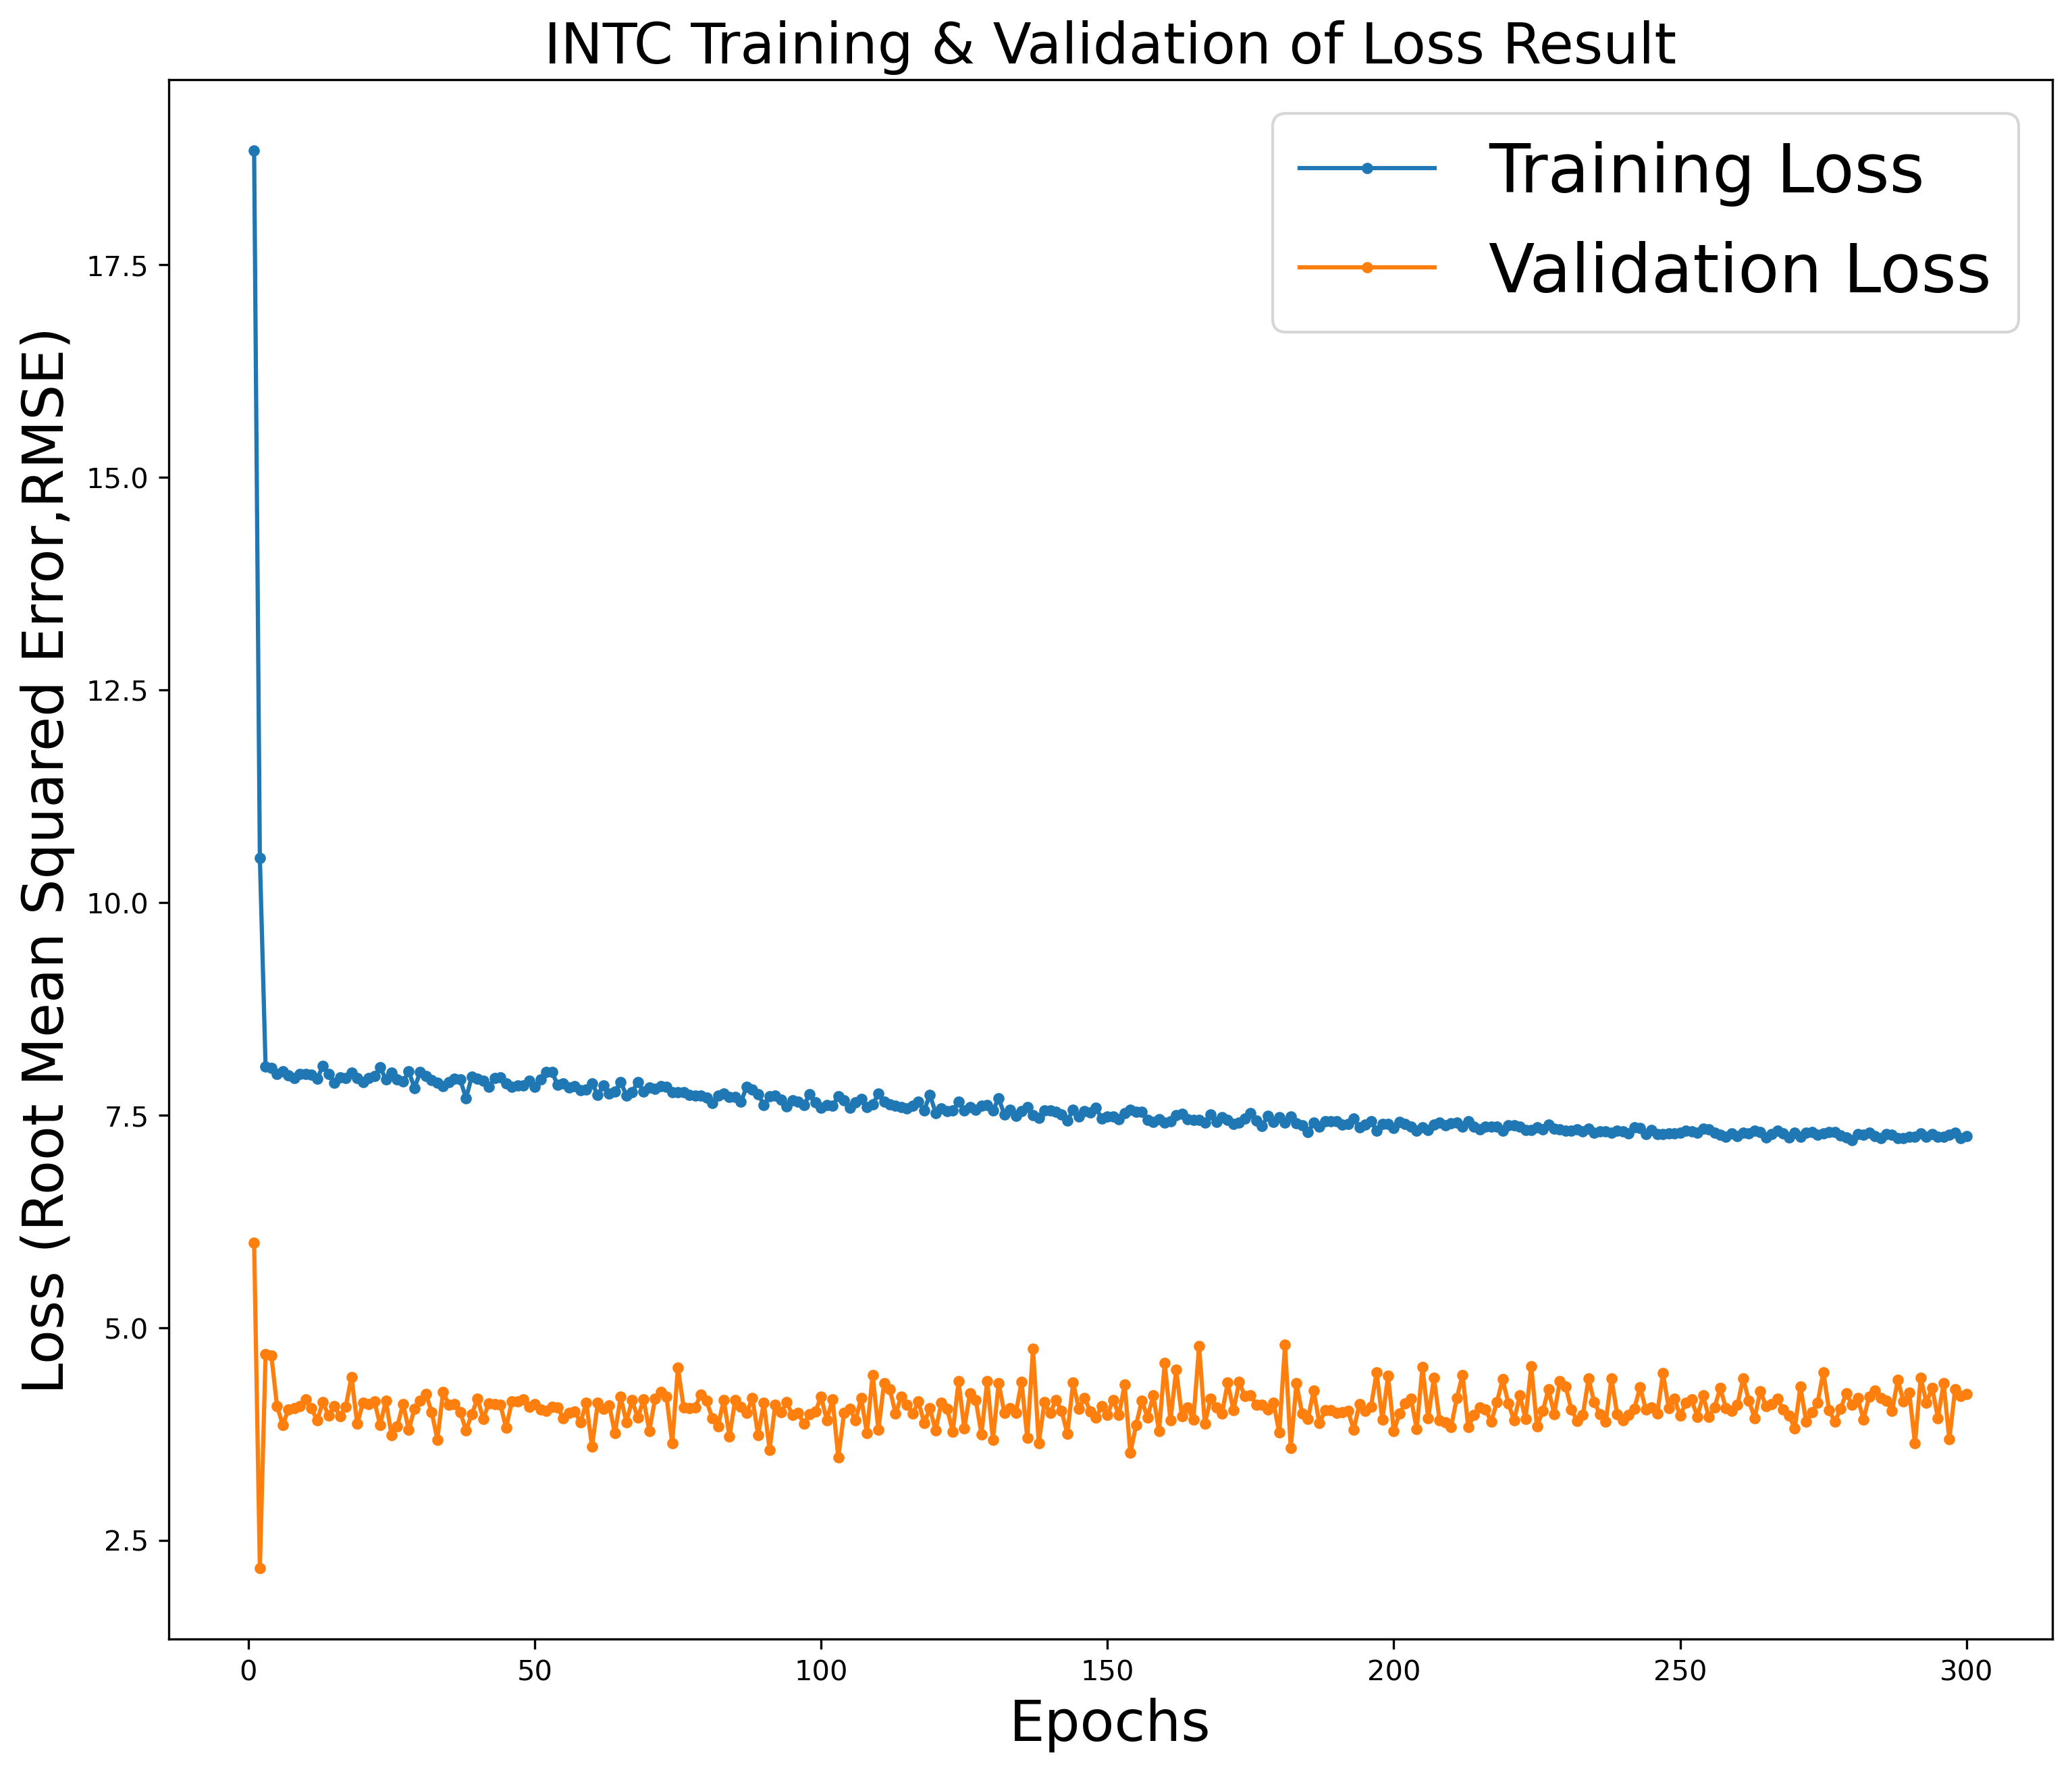

In [ ]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('INTC Training & Validation of Loss Result',fontsize=20)

plt.plot(epochs, training_loss_values, marker='.',label='Training Loss')
plt.plot(epochs, val_loss_values, marker='.',label='Validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

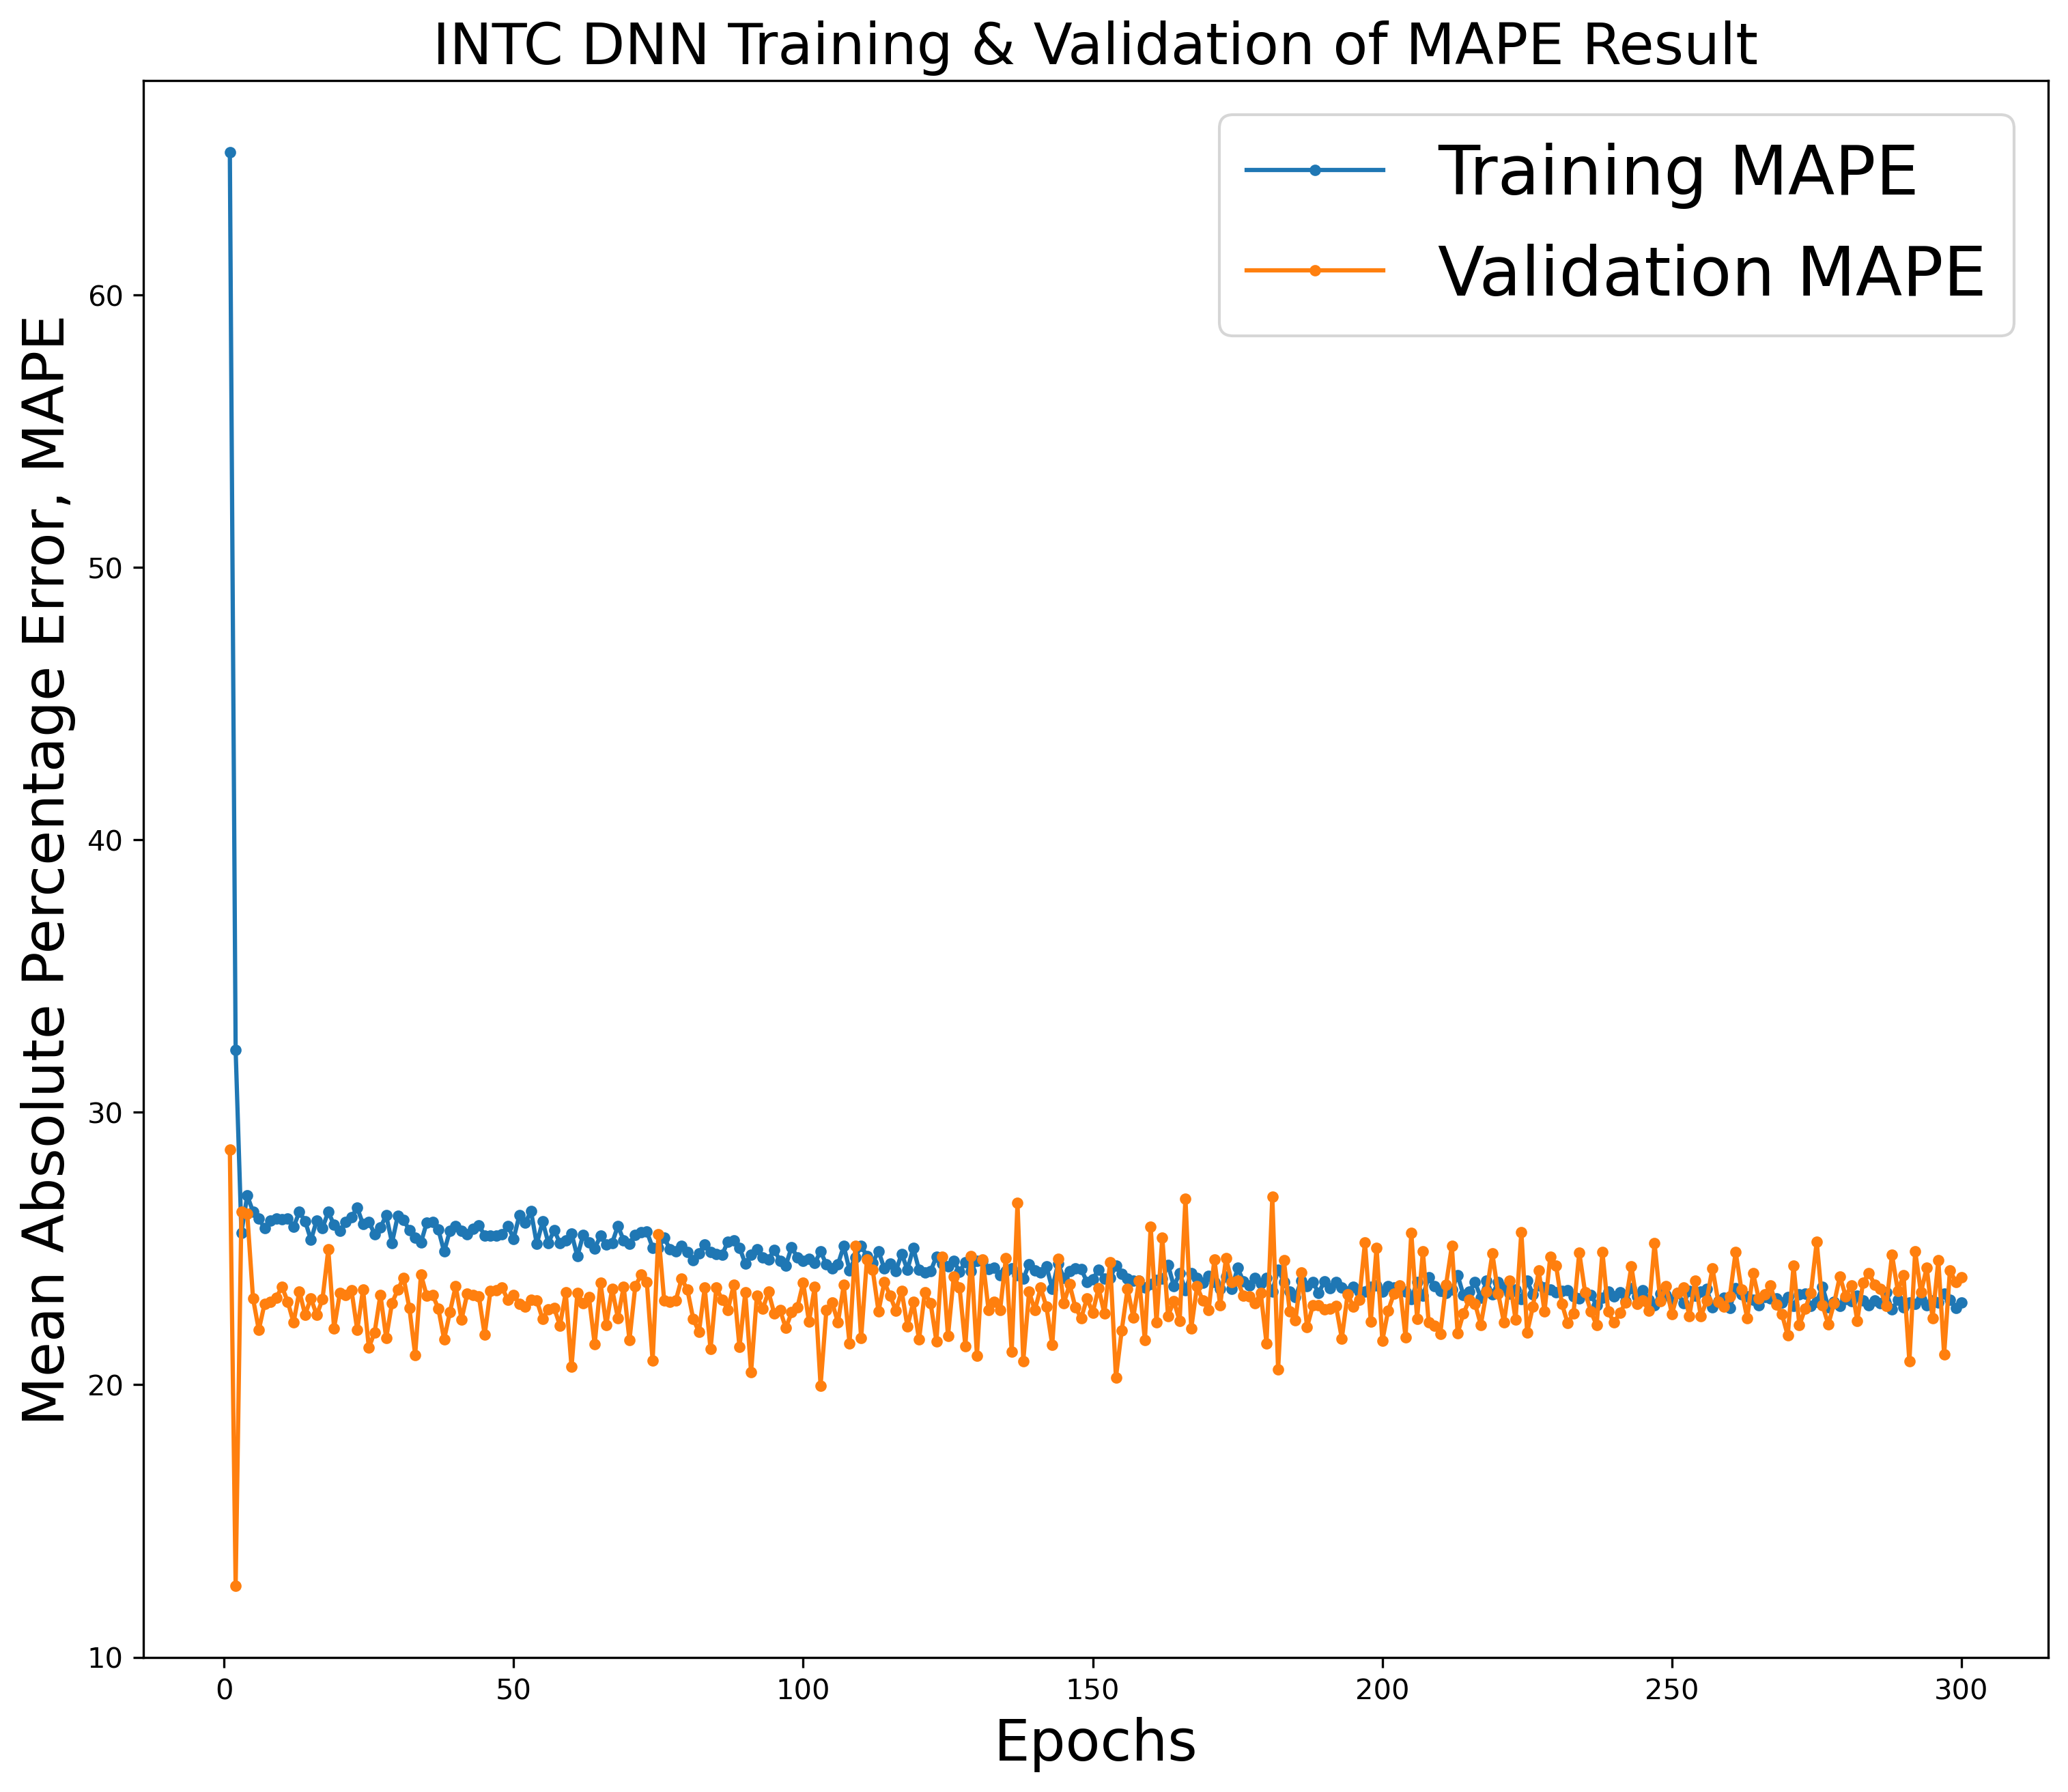

In [ ]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('INTC DNN Training & Validation of MAPE Result',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='Training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='Validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [ ]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Close all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [ ]:
# Create the model (Six Hidden)
clear.clear_session()
Fmodel=Sequential()

# First layer
Fmodel.add(Dense(units=120, input_dim=3))
#model.add(Dropout(0.5))

# Hidden layer
Fmodel.add(Dense(units=120, activation='tanh')) # 120, 100
Fmodel.add(Dropout(0.5))
Fmodel.add(Dense(units=120, activation='tanh')) # 120, 100
Fmodel.add(Dropout(0.5))
Fmodel.add(Dense(units=80, activation='tanh'))  # 80, 70
Fmodel.add(Dropout(0.5))
Fmodel.add(Dense(units=80, activation='tanh')) # 80, 70
Fmodel.add(Dropout(0.5))
Fmodel.add(Dense(units=40, activation='tanh')) # 40, 50
Fmodel.add(Dropout(0.5))
Fmodel.add(Dense(units=40, activation='tanh')) # 40, 50
Fmodel.add(Dropout(0.5))

# Output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01, beta_1=0.9, beta_2 = 0.999, epsilon = 1e-8)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               480       
                                                                 
 dense_1 (Dense)             (None, 120)               14520     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                                 
 dense_3 (Dense)             (None, 80)                9680      
                                                                 
 dropout_2 (Dropout)         (None, 80)                0

In [ ]:
# Create the model (Three Hidden)
clear.clear_session()
Fmodel3=Sequential()

# First layer
Fmodel3.add(Dense(units=120, input_dim=3))
#model.add(Dropout(0.5))

# Hidden layer
Fmodel3.add(Dense(units=120, activation='tanh')) # 120, 100
Fmodel3.add(Dropout(0.5))

Fmodel3.add(Dense(units=80, activation='tanh'))  # 80, 70
Fmodel3.add(Dropout(0.5))

Fmodel3.add(Dense(units=40, activation='tanh')) # 40, 50
Fmodel3.add(Dropout(0.5))


# Output layer
Fmodel3.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01, beta_1=0.9, beta_2 = 0.999, epsilon = 1e-8)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
Fmodel3.summary()

In [ ]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=128,verbose=1)

Epoch 1/300
36/36 [==============================] - 0s 2ms/step - loss: 14.1735 - mean_absolute_percentage_error: 48.5667
Epoch 2/300
36/36 [==============================] - 0s 2ms/step - loss: 7.5288 - mean_absolute_percentage_error: 26.6614
Epoch 3/300
36/36 [==============================] - 0s 2ms/step - loss: 7.3879 - mean_absolute_percentage_error: 26.1710
Epoch 4/300
36/36 [==============================] - 0s 2ms/step - loss: 7.3854 - mean_absolute_percentage_error: 26.1395
Epoch 5/300
36/36 [==============================] - 0s 2ms/step - loss: 7.3078 - mean_absolute_percentage_error: 25.7745
Epoch 6/300
36/36 [==============================] - 0s 2ms/step - loss: 7.2809 - mean_absolute_percentage_error: 25.7875
Epoch 7/300
36/36 [==============================] - 0s 2ms/step - loss: 7.3210 - mean_absolute_percentage_error: 25.7964
Epoch 8/300
36/36 [==============================] - 0s 2ms/step - loss: 7.2692 - mean_absolute_percentage_error: 25.9437
Epoch 9/300
36/36 [====

In [ ]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('INTC STOCK DNN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [ ]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('INTC STOCK DNN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [ ]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Close test
y_forecast_test=Forecast_test_data['Close'].copy()

In [ ]:
# 8.1 Make prediction
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [ ]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
4525,2018-01-02,46.849998,24.190001,22.659997
4526,2018-01-03,45.259998,24.190001,21.069997
4527,2018-01-04,44.430000,24.190001,20.239999
4528,2018-01-05,44.740002,24.190001,20.550001
4529,2018-01-08,44.740002,24.190001,20.550001
...,...,...,...,...
5882,2023-05-24,29.000000,24.190001,4.809999
5883,2023-05-25,27.400000,24.190001,3.209999
5884,2023-05-26,29.000000,24.190001,4.809999
5885,2023-05-30,29.990000,24.190001,5.799999


In [ ]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 24.208
MSE: 683.445
RMSE: 26.143
MAPE: 47.225 %
SMAPE: 63.81 %
RAE: 3.254
MRAE: 0.0023892865281965295
MdRAE: 5.318 bench: 48.398
RSE: 7.017
RRSE: 2.649


#  Plot for comparing true value & predicted value

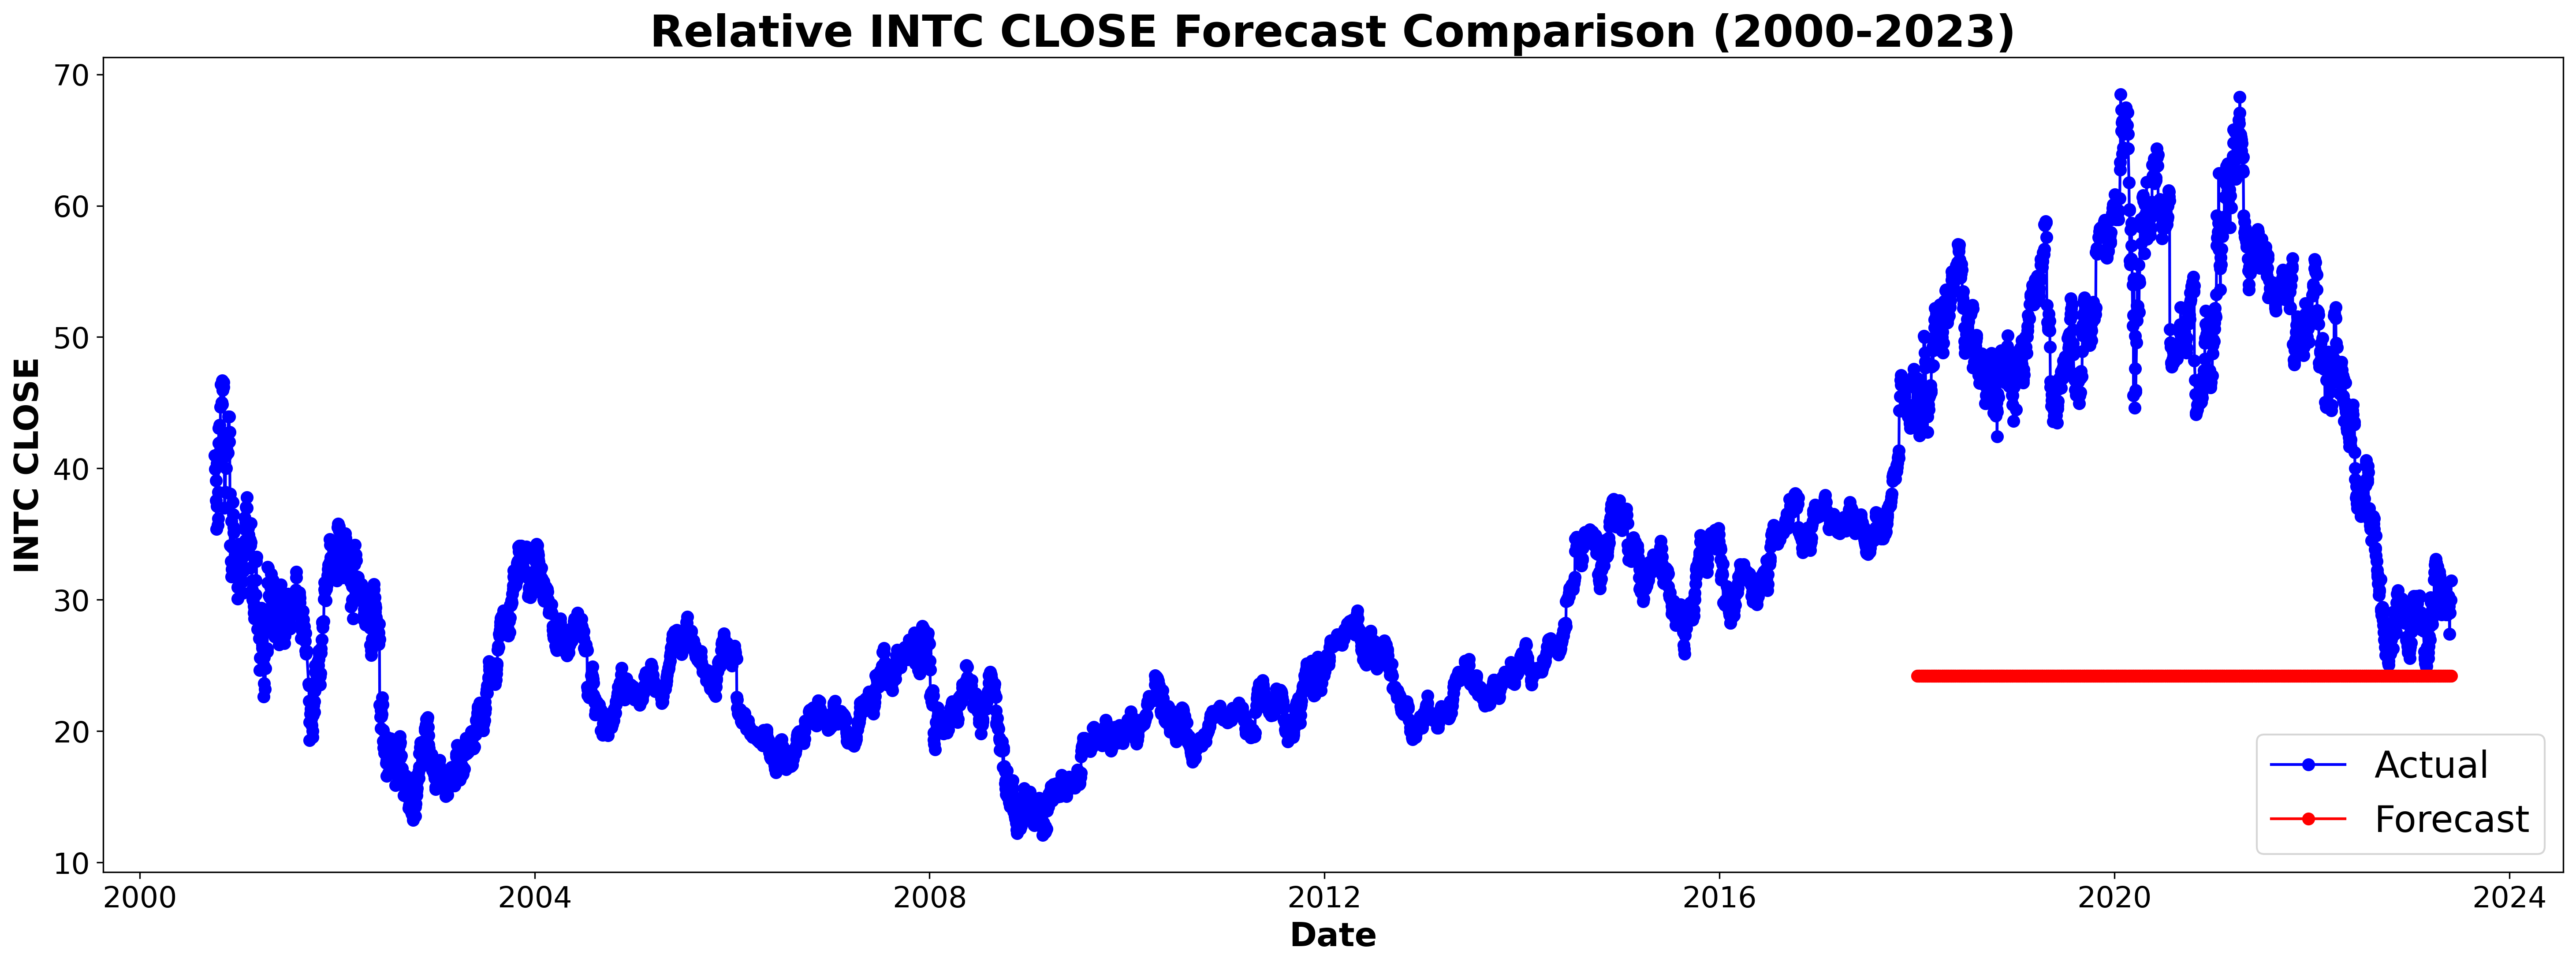

In [ ]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Relative INTC CLOSE Forecast Comparison (2000-2023)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('INTC CLOSE',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

In [ ]:
# Lock the scale of axis by Close_true
max_value=73
min_value=12

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Close-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,0],Results.iloc[:,3],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()